# Проект "Сообщающиеся маркетплейсы"

## Описание проекта

В рамках задания предоставлены данные одного из крупных маркетплейсов с информацией об истории потребительской активности клиентов, информацией о рассылках и получаемых сообщениях. В рамках проекта необходимо загрузить и провести работу с пятью таблицами с информацией по:

1. Сообщениям, полученным пользователями
2. Совершённых пользователем покупками
3. Таргету (совершение покупки в ближайшие 90 дней)
4. агрегированным данным по рассылкам
5. агрегированным данным по рассылкам с разбиением на каналы связи

Задача - сконструировать новые признаки, которые могут быть потенциально полезны для работы модели и на их основе построить модель бинарной классификации: факт совершения покупки в ближайшие 90 дней)

## Загрузка библиотек и основных функций

In [1]:
# Импортируем основные библиотеки для работы с данными
import pandas as pd
import numpy as np
from datetime import datetime as dt
from datetime import timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
import os
import glob
from IPython.display import display, Markdown
import shap 
import math

# Настраиваем пандас под себя
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Подключаем библиотеки для обучения моделей
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV, 
    train_test_split
)

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    LabelEncoder
)

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score, roc_auc_score, roc_curve, confusion_matrix

## Функции и константы

In [2]:
# Фиксируем основные константы
RANDOM_STATE = 42
TEST_SIZE = 0.25
IMPORTANT_VALUE_NUM = 0.02

In [3]:
def inf_replacement(data, # Таблица, бесконечности в которой надо заменить
                    replace_val=np.nan): # Значение для замены
    '''
    Функция для замены бесконечностей
    '''
    df = data.copy()
    for col in df.columns:
        if df[col].isin([np.inf, -np.inf]).any():
            mode = df.loc[~df[col].isin([np.inf]), col].mode()
            df[col] = df[col].replace([np.inf], replace_val)
    return df

# P.S. Почему-то через .replace я это сделать не додумался

In [4]:
# Функции для анализа данных
def boxplot_constructor(data, # Таблица, по которой надо построить графики
                        n_cols, # Количество колонок
                        figsize=(12, 6)): # Размер графиков
    '''
    Строит ящики с усами для поиска аномалий
    '''

    # Копируем исходный датасет
    df = data.copy()
    
    # Оставляем только колонки с числовыми признаками
    num_cols = df.select_dtypes(include=np.number).columns.to_list()

    # Проверяем, есть ли колонки с числами в принципе
    if num_cols == []:
        print('В таблице нет колонок с числовыми признаками')
        return

    # Вычисляем количество строк как частное колонок таблицы и колонок графиков, которую мы указали в параметрах ф-ции
    n_rows = math.ceil(len(num_cols) / n_cols)

    # Строим фигуры
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1] * n_rows))

    # Пробегаемся по колонкам и строим по ним графики, графики записываем в матрицу
    for i, col in enumerate(num_cols):
        r_idx = i // n_cols
        c_idx = i % n_cols

        df[col].plot.box(ax=axes[r_idx, c_idx])
        axes[r_idx, c_idx].set_title(f'Боксплот для {col}')
        axes[r_idx, c_idx].set_ylabel(col)

    plt.show()

def pie_constructor(data, # Таблица, по которой надо построить графики
                        n_cols, # Количество колонок
                        figsize=(12, 6)): # Размер графиков
    '''
    Строим графики по столбцам с категориальными значениями
    '''
    
    # Копируем исходную таблицу
    df = data.copy()

    # Записываем колонки с категориальными признаками в массив
    cat_cols = []
    for col in df.columns:
        if df[col].nunique() <= 8:
            cat_cols.append(col)
    
    # Проверяем, есть ли колонки с категориальными признаками в принципе
    if cat_cols == []:
        print('В таблице нет колонок с числовыми признаками')
        return

    # Вычисляем количество строк в матрице графиков
    n_rows = math.ceil(len(cat_cols) / n_cols)

    # Строим эскиз матрицы
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1] * n_rows))

    # Пробегаемся по колонкам таблицы и записываем графики в матрицу
    for i, col in enumerate(cat_cols):
        r_idx = i // n_cols
        c_idx = i % n_cols

        df[col].value_counts().plot.pie(ax=axes[r_idx, c_idx], autopct='%1.1f%%')
        axes[r_idx, c_idx].set_title(f'Боксплот для {col}')
        axes[r_idx, c_idx].set_ylabel(col)

    plt.show()

def hist_constructor(data, # Таблица, по которой надо построить графики
                        n_cols, # Количество колонок
                        figsize=(12, 6)): # Размер графиков
    '''
    Строим графики по столбцам с категориальными значениями
    '''
    
    # Копируем исходную таблицу
    df = data.copy()
    
    # Записываем колонки с категориальными признаками в массив
    num_cols = df.select_dtypes(include=np.number).columns.to_list()

    # Проверяем наличие столбцов с числами
    if num_cols == []:
        print('В таблице нет колонок с числовыми признаками')
        return

    # Вычисляем количество строк в матрице графиков
    n_rows = math.ceil(len(num_cols) / n_cols)

    # Строим эскиз матрицы
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], figsize[1] * n_rows))

    # Пробегаемся по колонкам таблицы и записываем графики в матрицу
    for i, col in enumerate(num_cols):
        r_idx = i // n_cols
        c_idx = i % n_cols

        df[col].plot.hist(ax=axes[r_idx, c_idx], bins=50)
        axes[r_idx, c_idx].set_title(f'Боксплот для {col}')
        axes[r_idx, c_idx].set_ylabel(col)

    plt.show()

In [5]:
def phik_data(data): # Таблица, которую надо подготовить к построению матрицы phik
    
    '''
    Функция для подготовки данных к построению матрицы корреляции
    Берёт датасет, возвращает его же, но без "лишних" колонок и с названиями столбцов, 
    для которых может быть использована интервальная модель вычисления корреляции
    '''
    
    # Убираем идентификаторы из корреляционного анализа
    if 'client_id' in data.columns:
        data = data.drop(columns='client_id')

    # Берём только числовые колонки
    num_col_names = data.select_dtypes(include='number').columns
    interval_col_names = []

    # Записываем в массив только те колонки, в которых больше 10 уникальных значений
    for column in num_col_names:
        if data[column].nunique() > 10:
            interval_col_names.append(column)
    return data, interval_col_names # Выводит преобразованный датасет без "id" и имена столбцов с дискретными признаками

In [6]:
def data_drop(df, 
              corr_matrix, 
              target_col,
              important_value_num=0.02): # Функция, которая отсеивает наименее важные признаки
    
    temp = corr_matrix[target_col].sort_values()
    cols_to_drop = temp[temp<important_value_num].index
    return df.drop(cols_to_drop, axis=1)

In [7]:
def preprocessor_creator(ohe_cols,
                         num_cols):

    '''
    Функция для построения пайплайна кодирования данных
    При этом в задаче классификации придётся кодировать и сэмплировать данные отдельно
    '''
    
    # кодировщик категориальных признаков
    ohe_pipe = Pipeline(
        [
            ('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(drop='first', 
                                  handle_unknown='ignore', 
                                  sparse_output=False))
        ]
    )
    
    
    # кодировщик числовых признаков
    scaler_pipe = Pipeline(
    [
        ('simpleImputer_num', SimpleImputer(strategy='median')),
        ('standard', StandardScaler())
    ]
    )

    data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_cols),
    ('num', scaler_pipe, num_cols)])

    return data_preprocessor

def col_names_func(df): 
    '''
    функция для разделения строк по типам
    '''
    num_col_names = df.select_dtypes(include='number').columns
    cat_col_names = df.select_dtypes(exclude='number').columns
    for col in df.columns:
        if df[col].nunique == 2:
            cat_col_names.append(col)
    return num_col_names, cat_col_names

In [8]:

def fill_missing_by_dtype(df, numeric_fill='median', categorical_fill='mode', inplace=False):
    
    if not inplace:
        df = df.copy()
    
    for column in df.columns:
        # Пропускаем столбцы без пропусков
        if df[column].isnull().sum() == 0:
            continue
            
        # Определяем тип данных столбца
        dtype = str(df[column].dtype)
        
        # Числовые столбцы
        if np.issubdtype(df[column].dtype, np.number):
            if numeric_fill == 'median':
                fill_value = df[column].median()
            elif numeric_fill == 'mean':
                fill_value = df[column].mean()
            else:
                fill_value = numeric_fill
        # Категориальные/текстовые столбцы
        else:
            if categorical_fill == 'mode':
                # Берем первое значение моды (может быть несколько)
                fill_value = df[column].mode().iloc[0] if not df[column].mode().empty else 'unknown'
            else:
                fill_value = categorical_fill
        
        # Заполняем пропуски
        df[column].fillna(fill_value, inplace=True)
        
        # Выводим информацию о заполнении
        print(f"Столбец '{column}': заполнено {df[column].isnull().sum()} пропусков значением {fill_value}")
    
    return df if not inplace else None

In [9]:
def calculate_fill_value(series, 
                          is_numeric):
    '''
    Функция для получения медианы или моды в зависимости от типа данных в столбце
    '''

    if is_numeric:
        return series.mean()
    else:
        return series.mode()[0]


def cats_fillna(df, 
                primary_col, 
                secondary_col, 
                target_col):
    '''
    Функция для заполнения пропусков с применением двойной группировки
    '''

    result_df = df.copy()
    is_numeric = pd.api.types.is_numeric_dtype(result_df[target_col])
    
   
    primary_values = result_df[primary_col].unique()
    secondary_values = result_df[secondary_col].unique()

    # цикл для двойной категоризации с заполнением пропусков
    for primary_value in primary_values:
        primary_mask = result_df[primary_col] == primary_value
        
        for secondary_value in secondary_values:
            secondary_mask = result_df[secondary_col] == secondary_value
            combo_mask = primary_mask & secondary_mask
            
            if not combo_mask.any():
                continue
                
            non_na_values = result_df.loc[combo_mask, target_col].dropna()
            if len(non_na_values) == 0:
                continue
                
      
            if is_numeric:
                fill_value = non_na_values.mean()
            else:
                fill_value = non_na_values.mode()[0]
                
            nan_mask = combo_mask & result_df[target_col].isna()
            if nan_mask.any():
                result_df.loc[nan_mask, target_col] = fill_value
    

    # Если пропуски остаются, то заполняем только по приоритетной категории
    if result_df[target_col].isna().any():
        for primary_value in primary_values:
            primary_mask = result_df[primary_col] == primary_value
            
            non_na_values = result_df.loc[primary_mask, target_col].dropna()
            if len(non_na_values) == 0:
                continue
                

            if is_numeric:
                fill_value = non_na_values.mean()
            else:
                fill_value = non_na_values.mode()[0]
                
            nan_mask = primary_mask & result_df[target_col].isna()
            if nan_mask.any():
                result_df.loc[nan_mask, target_col] = fill_value

    # Если пропуски остаются, заполняем их по среднему/моде во всём столбце
    if result_df[target_col].isna().any():
        non_na_values = result_df[target_col].dropna()
        if len(non_na_values) > 0:
            fill_value = calculate_fill_value(non_na_values, is_numeric)
            result_df[target_col] = result_df[target_col].fillna(fill_value)
    
    return result_df

# P.S. Как же я намучился с этой функцией......

In [10]:
def evaluate_classifier(classifier, # Модель
                        X_test, y_test, # Тестовые данны
                        model_name): # Наименование модели для графиков
                        
    '''
    Функция для рассчёта и вывода метрик и графиков показателей качества модели
    '''
    # Получение предсказаний
    y_pred = classifier.predict(X_test)
    y_proba = classifier.predict_proba(X_test)[:, 1]
    
    # Рассчёт метрики
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC AUC score: {roc_auc:.4f}")
    
    # Рассчёт данных для графика
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    
    # Рассчёт матрицы ошибок
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    print("\nConfusion Matrix:")
    print(f"True Negatives: {tn}, False Positives: {fp}")
    print(f"False Negatives: {fn}, True Positives: {tp}")
    
    # Построение матрицы ошибок
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    
    # Построение ROC-кривой
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

## Загрузка и ознакомление с данными

In [11]:
# Загрузка имён всех CSV-файлов
csv_list = glob.glob('*.csv')
csv_list.sort()

# Проверка на то, загрузились ли те файлы
csv_list_check = ['apparel-messages.csv',
                  'apparel-purchases.csv',
                  'apparel-target_binary.csv',
                  'full_campaign_daily_event.csv',
                  'full_campaign_daily_event_channel.csv']

# Создаём словарь для записи датасетов
df_dict = {}

try:

    '''
    В зависимости от условия соответствия проверочному списку файлов
    записываем датасеты в словарь и выводим информацию о том, какой файл куда был записан
    '''
    
    if len(csv_list) == 5 and csv_list_check == csv_list:
        for i, file in enumerate(csv_list, start=1):
            df_name = f'df_{i}'
            df_dict[df_name] = pd.read_csv(file)
            globals()[df_name] = df_dict[df_name]
            print(f'Данные из {file} загружены в df_{i}')
            
    elif len(csv_list) > 5:
        for i, file in enumerate(csv_list, start=1):
            df_name = f'df_{i}'
            df_dict[df_name] = pd.read_csv(file)
            globals()[df_name] = df_dict[df_name]
            print(f'Данные из {file} загружены в df_{i}')
        print('Загружены "лишние" файлы')
        
    elif len(csv_list) < 5:
        for i, file in enumerate(csv_list, start=1):
            df_name = f'df_{i}'
            df_dict[df_name] = pd.read_csv(file)
            globals()[df_name] = df_dict[df_name]
            print(f'Данные из {file} загружены в df_{i}')
        print('Не все файлы проекта загружены')
        
    elif len(csv_list) == 5 and csv_list_check != csv_list:
        for i, file in enumerate(csv_list, start=1):
            df_name = f'df_{i}'
            df_dict[df_name] = pd.read_csv(file)
            globals()[df_name] = df_dict[df_name]
            print(f'Данные из {file} загружены в df_{i}')
        print('Загружены файлы с иными наименованиями, убедитесь в целостности данных')
        
except:
    print('Возникла непредвиденная ошибка')

finally:
    print('Скрипт закончил работу')

Данные из apparel-messages.csv загружены в df_1
Данные из apparel-purchases.csv загружены в df_2
Данные из apparel-target_binary.csv загружены в df_3
Данные из full_campaign_daily_event.csv загружены в df_4
Данные из full_campaign_daily_event_channel.csv загружены в df_5
Скрипт закончил работу


In [12]:
# Получаем информацию о данных в таблицах в словаре
for df_name, df in df_dict.items():
    print(f'Информация о данных в {df_name}')
    display(df_dict[df_name].info())
    print('\n')

Информация о данных в df_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


None



Информация о данных в df_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


None



Информация о данных в df_3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None



Информация о данных в df_4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nuniq

None



Информация о данных в df_5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null 

None

In [13]:
for df_name, df in df_dict.items():
    print(f'Первые 5 строк {df_name}')
    display(df_dict[df_name].tail())
    print('\n')

Первые 5 строк df_1


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
12739793,14657,1515915625477497874,1515915625477497874-14657-65cdd371cc86c,open,email,2024-02-15,2024-02-15 23:51:40
12739794,14657,1515915625765994334,1515915625765994334-14657-65cdd36018eac,open,email,2024-02-15,2024-02-15 23:52:20
12739795,14641,1515915625545014677,1515915625545014677-14641-65cb2434b25a1,open,email,2024-02-15,2024-02-15 23:52:40
12739796,14624,1515915625477497874,1515915625477497874-14624-65c5e22fb401e,open,email,2024-02-15,2024-02-15 23:58:40
12739797,14641,1515915625477497874,1515915625477497874-14641-65cb249172d68,open,email,2024-02-15,2024-02-15 23:58:40




Первые 5 строк df_2


,client_id,quantity,price,category_ids,date,message_id
202203,1515915626010261344,1,1499.00,"['2', '18', '212', '726']",2024-02-16,1515915626010261344-14648-65cdb6d56c4c8
202204,1515915626010439406,1,99.00,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202205,1515915626010439406,1,99.00,"['4', '27', '233', '462']",2024-02-16,1515915625776605028-14662-65cf3abfe4f0d
202206,1515915626010443527,1,1999.00,"['2', '18', '274', '446']",2024-02-16,1515915625766077627-14668-65cf5246bd490
202207,1515915626010443624,1,999.00,"['4', '28', '62', '656']",2024-02-16,1515915625488468007-14668-65cf5234b1295




Первые 5 строк df_3


,client_id,target
49844,1515915626010261344,0
49845,1515915626010266132,0
49846,1515915626010439406,0
49847,1515915626010443527,0
49848,1515915626010443624,0




Первые 5 строк df_4


,date,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
131067,2024-05-15,15067,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,15,0,0,0,0
131068,2024-05-15,15096,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,10,0,0,0,0
131069,2024-05-15,15102,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,12,0,0,0,0
131070,2024-05-15,15116,0,0,0,0,0,0,0,1,33,0,0,0,0,0,0,0,1,32,0,0,0,0
131071,2024-05-15,15148,0,0,0,0,0,0,3,6,589,0,0,0,0,0,0,3,6,556,0,0,0,0




Первые 5 строк df_5


,date,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
131067,2024-05-15,15067,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
131068,2024-05-15,15096,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
131069,2024-05-15,15102,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
131070,2024-05-15,15116,0,0,0,0,0,0,0,1,33,0,0,0,0,0,0,0,1,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
131071,2024-05-15,15148,0,0,0,0,0,0,3,6,589,0,0,0,0,0,0,3,6,556,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
for df_name, df in df_dict.items():
    print(f'Информация о данных в {df_name}')
    display(df_dict[df_name].describe())
    print('\n')

Информация о данных в df_1


,bulk_campaign_id,client_id
count,12739798.00,12739798.00
mean,11604.59,1515915625574831616.00
std,3259.21,326551798.16
min,548.00,1515915625468060928.00
25%,8746.00,1515915625489149440.00
50%,13516.00,1515915625503432192.00
75%,14158.00,1515915625591286272.00
max,14657.00,1515915626010288640.00




Информация о данных в df_2


,client_id,quantity,price
count,202208.00,202208.00,202208.00
mean,1515915625596210944.00,1.01,1193.30
std,145951436.37,0.18,1342.25
min,1515915625468060928.00,1.00,1.00
25%,1515915625490081280.00,1.00,352.00
50%,1515915625557177088.00,1.00,987.00
75%,1515915625624391936.00,1.00,1699.00
max,1515915626010443520.00,30.00,85499.00




Информация о данных в df_3


,client_id,target
count,49849.00,49849.00
mean,1515915625598796032.00,0.02
std,148794665.09,0.14
min,1515915625468060928.00,0.00
25%,1515915625489972736.00,0.00
50%,1515915625556614912.00,0.00
75%,1515915625633408768.00,0.00
max,1515915626010443520.00,1.00




Информация о данных в df_4


,bulk_campaign_id,count_click,count_complain,count_hard_bounce,count_open,count_purchase,count_send,count_soft_bounce,count_subscribe,count_unsubscribe,nunique_click,nunique_complain,nunique_hard_bounce,nunique_open,nunique_purchase,nunique_send,nunique_soft_bounce,nunique_subscribe,nunique_unsubscribe,count_hbq_spam,nunique_hbq_spam,count_close,nunique_close
count,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00
mean,8416.74,90.98,0.93,78.47,3771.09,0.58,11634.14,27.81,0.14,6.36,74.28,0.92,77.40,3683.00,0.47,11537.16,27.57,0.13,5.96,0.81,0.81,0.00,0.00
std,4877.37,1275.50,30.20,1961.32,65160.67,9.11,175709.51,736.94,2.07,79.17,1004.27,29.72,1913.40,62586.47,7.13,172700.49,734.05,1.98,73.28,183.30,183.30,0.00,0.00
min,548.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4116.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,7477.00,0.00,0.00,0.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,13732.00,2.00,0.00,0.00,30.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,30.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
max,15150.00,128453.00,5160.00,287404.00,5076151.00,1077.00,11543513.00,76284.00,189.00,9089.00,75899.00,5043.00,287341.00,2922440.00,779.00,7094600.00,76281.00,177.00,8299.00,63920.00,63920.00,1.00,1.00




Информация о данных в df_5


,bulk_campaign_id,count_click_email,count_click_mobile_push,count_open_email,count_open_mobile_push,count_purchase_email,count_purchase_mobile_push,count_soft_bounce_email,count_subscribe_email,count_unsubscribe_email,nunique_click_email,nunique_click_mobile_push,nunique_open_email,nunique_open_mobile_push,nunique_purchase_email,nunique_purchase_mobile_push,nunique_soft_bounce_email,nunique_subscribe_email,nunique_unsubscribe_email,count_hard_bounce_mobile_push,count_send_mobile_push,nunique_hard_bounce_mobile_push,nunique_send_mobile_push,count_hard_bounce_email,count_hbq_spam_email,count_send_email,nunique_hard_bounce_email,nunique_hbq_spam_email,nunique_send_email,count_soft_bounce_mobile_push,nunique_soft_bounce_mobile_push,count_complain_email,nunique_complain_email,count_close_mobile_push,nunique_close_mobile_push
count,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00,131072.00
mean,8416.74,41.58,49.40,423.71,3347.38,0.36,0.22,24.47,0.14,6.36,31.40,42.88,411.66,3271.34,0.29,0.18,24.26,0.13,5.96,59.48,7444.56,58.86,7350.27,18.99,0.81,4189.58,18.54,0.81,4186.90,3.33,3.31,0.93,0.92,0.00,0.00
std,4877.37,745.48,1036.95,9753.38,64448.59,8.29,3.80,727.07,2.07,79.17,562.88,833.32,9519.71,61880.01,6.48,2.97,724.27,1.98,73.28,1371.96,139350.92,1357.27,135579.92,1402.41,183.30,107319.76,1349.47,183.30,107261.80,120.92,120.09,30.20,29.72,0.00,0.00
min,548.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,4116.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,7477.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,13732.00,1.00,0.00,23.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,23.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,15150.00,59365.00,128453.00,2597015.00,5076151.00,1077.00,431.00,76284.00,189.00,9089.00,45718.00,75899.00,2548617.00,2922440.00,779.00,359.00,76281.00,177.00,8299.00,165526.00,11543513.00,165526.00,6636578.00,287404.00,63920.00,7094600.00,287341.00,63920.00,7094600.00,21831.00,21389.00,5160.00,5043.00,1.00,1.00


In [15]:
for df_name, df in df_dict.items():
    print(f'Информация о данных в {df_name}')
    display(df_dict[df_name].info())
    print('\n')

Информация о данных в df_1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


None



Информация о данных в df_2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


None



Информация о данных в df_3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


None



Информация о данных в df_4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   date                 131072 non-null  object
 1   bulk_campaign_id     131072 non-null  int64 
 2   count_click          131072 non-null  int64 
 3   count_complain       131072 non-null  int64 
 4   count_hard_bounce    131072 non-null  int64 
 5   count_open           131072 non-null  int64 
 6   count_purchase       131072 non-null  int64 
 7   count_send           131072 non-null  int64 
 8   count_soft_bounce    131072 non-null  int64 
 9   count_subscribe      131072 non-null  int64 
 10  count_unsubscribe    131072 non-null  int64 
 11  nunique_click        131072 non-null  int64 
 12  nunique_complain     131072 non-null  int64 
 13  nunique_hard_bounce  131072 non-null  int64 
 14  nunique_open         131072 non-null  int64 
 15  nuniq

None



Информация о данных в df_5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131072 entries, 0 to 131071
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype 
---  ------                           --------------   ----- 
 0   date                             131072 non-null  object
 1   bulk_campaign_id                 131072 non-null  int64 
 2   count_click_email                131072 non-null  int64 
 3   count_click_mobile_push          131072 non-null  int64 
 4   count_open_email                 131072 non-null  int64 
 5   count_open_mobile_push           131072 non-null  int64 
 6   count_purchase_email             131072 non-null  int64 
 7   count_purchase_mobile_push       131072 non-null  int64 
 8   count_soft_bounce_email          131072 non-null  int64 
 9   count_subscribe_email            131072 non-null  int64 
 10  count_unsubscribe_email          131072 non-null  int64 
 11  nunique_click_email              131072 non-null 

None

Итак, для начала надо определиться, что концептуально можно сделать с данными.

**По данным о покупках клиентов df_2:**

1. Посчитать метрики по типу среднего чека

2. информацию о наличии/числу покупок за последний месяц/квартал

3. любимая категория товара (взять как первую/последнюю категорию в массиве). Также можно подумать о возможности использования MultiLabelBinarizer (только пока я не придумал, как конкретно это использовать, так как надо предсказывать поведение уникальных клиентов, а не какого-либо показателя совершённой покупки

**По данным о рассылках (df_4, df_5):**

1. Можно посчитать конверсии: коэффициент открытия, коэффициент кликов, конверсия в покупки, количество жалоб по рассылке, отказов, отписок и прочее

2. Временные метрики по рассылкам: была ли рассылка в прайм-тайм, была ли рассылка в выходные, была ли рассылка в сезон (думал сделать по категориям, но я не знаю расшифровок идентификаторов, поэтому будем анализировать по временным рядам в EDA)

3. Из этих данных будет крайне полезно достать признаки по клиенту: коэффициент открытия, предпочитаемый канал рассылки, действие с последним письмом (можно свести к признаку открыл/не открыл), количество дней, прошедших с момента получения последнего сообщения (или количество сообщений за последние 7/30/90 дней), конверсия в покупки, соотношение "хороших" и "плохих" событий

связать это можно будет через apparel_messages

Важно, что при исследовательском анализе имеет смысл работать только с данными, которые непосредственно будут участвовать в модели: то есть сначала необходимо придумать признаки, сгруппировать и агрегировать, а затем анализировать. Иначе анализ, который будет выходить за рамки ознокомительного, будет обречён на многостраничный текст с описанием графиков по 100+ признакам: 72 изначальным фичам, плюс тем, что мы потенциально сможем придумать.

Также важно, что датасеты по рассылкам вообще можно не использовать, а работать только с таблицей apparel_messages, к чему по итогу я и пришёл

У данных также есть несоответствие типов, притом что явных пропусков нет

## Предобработка данных

In [16]:
# Проверяем данные на наличие дубликатов
for df in [df_1, df_2, df_3, df_4, df_5]:
    display(df.duplicated().sum())

np.int64(48610)

np.int64(73020)

np.int64(0)

np.int64(0)

np.int64(0)

Дубликаты есть только в данных по сообщениям и по покупкам. Если в данных по сообщениям дубликаты ещё не кажутся странными, могла возникнуть ошибка, когда пришли два сообщения одновременно (точнее, понятно, что с ними делать, их всего две десятые процента, можно просто их удалить), то что делать с данными по покупкам, я ума не приложу.

Вообще, конечно, можно с лёгкостью представить, что один и тот же человек в один день совершает одну и ту же покупку два раза (может он не то количество выставил изначально или, допустим, он утром заказал один товар, а под вечер подумал и решил, что надо бы заказать ещё один), но тогда придётся признать, что так делает каждый третий клиент. Очень возможно, что есть ошибка в процессе сбора данных, но резать треть таблицы у меня рука не поднимается

Проверим данные на наличие неявных дубликатов и пропусков

In [17]:

for df in [df_1, df_2, df_4, df_5]:
    df['date'] = pd.to_datetime(df['date'])

df_1['created_at'] = pd.to_datetime(df_1['created_at'])

display(set(df_2['category_ids'].unique()))

df_2['category_ids'] = df_2['category_ids'].apply(eval)
df_2['category_ids'] = df_2['category_ids'].apply(lambda x: x[0] if len(x) > 0 else np.nan)


{"['1', '22', '50', '685']",
 "['1', '8', '280', '710']",
 "['2', '17', '107', '453']",
 "['2', '17', '137', '469']",
 "['2', '17', '171', '475']",
 "['2', '17', '173', '1598']",
 "['2', '17', '173', '1845']",
 "['2', '17', '173', '459']",
 "['2', '17', '180', '465']",
 "['2', '17', '1826', '1818']",
 "['2', '17', '188', '525']",
 "['2', '17', '198', '497']",
 "['2', '17', '232', '463']",
 "['2', '17', '279', '5807']",
 "['2', '17', '286', '455']",
 "['2', '17', '293', '5819']",
 "['2', '17', '330', '387', '467']",
 "['2', '17', '83', '519']",
 "['2', '17', '83', '5810']",
 "['2', '18', '123', '451']",
 "['2', '18', '155', '1325']",
 "['2', '18', '155', '439']",
 "['2', '18', '212', '658']",
 "['2', '18', '212', '659']",
 "['2', '18', '212', '726']",
 "['2', '18', '217', '662']",
 "['2', '18', '217', '663']",
 "['2', '18', '243', '440']",
 "['2', '18', '248', '449']",
 "['2', '18', '248', '677']",
 "['2', '18', '258', '1195']",
 "['2', '18', '258', '1561']",
 "['2', '18', '258', '1562'

В идентификаторах есть пропуски, их надо будет обработать. И в принципе надо сделать из этого нормальные словари, а для того, чтобы можно было бы работать с данными и дальше, можно взять только первую укрупнённую категорию.

In [18]:


for df in [df_1, df_2, df_3, df_4, df_5]:
    
    for column in df.columns:
        
        if (
            ((df[column].dtype == 'object' or df[column].dtype == 'string') 
            and 
            'id' not in column)

            or column == 'category_ids'
        ):
            
            print(f'\n{column:-^30}')
            display(df[column].value_counts())

'''
В некоторых списках были либо None, либо они были пустыми 
и при выборе первого элемента оставили np.nan, поэтому заменил их на неизвестную категорию
'''

df_2['category_ids'] = df_2['category_ids'].fillna('unknown')


------------event-------------


event
send           9058196
open           3085820
click           496339
purchase         64679
hard_bounce      19903
soft_bounce      10583
unsubscribe       2841
hbq_spam           823
complain           528
subscribe           85
close                1
Name: count, dtype: int64


-----------channel------------


channel
mobile_push    7512156
email          5227642
Name: count, dtype: int64


---------category_ids---------


category_ids
4       112578
5562     46511
2        27429
6060      7559
5963      1272
3           11
1            3
5            2
Name: count, dtype: int64

Вообще есть очень сильный дисбаланс по категориям. Товары трёх из них (1, 3, 5) суммарно покупались только 16 раз

То же самое наблюдается и по статистике наступления какого-либо события по сообщению. Закрыли сообщение только 1 раз (мб какая-то ошибка или я не понимаю, что означает категория "close"), чаще всего они были отправлены, но не были открыты (если я правильно понял, что именно это подразумевается под send). Вторыми и третьими по популярности являются открытие сообщения и клик по ссылке в сообщении. Покупок после получения сообщений было всего 65 тысяч. 

По статистике каналов рассылок видно, что пуш-уведомления чуть популярнее, чем получение рассылок по электонной почте

## Пытаемся конструировать новые признаки

**По датасету с сообщениями**

In [40]:
# Для каждого ивента конструируем отдельный столбец с флагом его наступления в сообщении
# По факту проводим свой one hot encoding для последующей группировки
for cat in df_1['event'].unique():
    df_1[cat] = (df_1['event'] == cat).astype(int)

# Записываем отдельно датасет с группировками, которые потом соединим 
# P.S. Я только потом допёр, что можно так то в словарь записать, какую фигню ты можешь сделать с данными, а не соединять по отдельности это
data_event = df_1.groupby('client_id')[df_1['event'].unique()].sum()
data_event['client_id'] = data_event.index
data_event = data_event.reset_index(drop=True)
data_event['good_events'] = data_event[['open', 'click', 'purchase', 'send', 'subscribe']].sum(axis=1)
data_event['bad_events'] = data_event[['unsubscribe', 'hbq_spam', 'hard_bounce', 'soft_bounce', 'complain', 'close']].sum(axis=1)

# Для каналов рассылки делаем то же самое
for cat in df_1['channel'].unique():
    df_1[cat] = (df_1['channel'] == cat).astype(int)

data_channel = df_1.groupby('client_id')[df_1['channel'].unique()].sum()
data_channel['client_id'] = data_channel.index
data_channel = data_channel.reset_index(drop=True)

# Выделяем сообщения, по которым в последние 30 дней происходили изменения
date_check = max(df_1['date']) - timedelta(days=30)
df_1['last_30_days_massage'] = (df_1['date'] > date_check).astype('int')
data_massage_month = df_1.groupby('client_id')['last_30_days_massage'].max()
data_massage_month = data_massage_month.reset_index(name='last_30_days_massage')

data_massages_sent = df_1.groupby('client_id').size().reset_index(name='massages_recieved')

In [41]:
# Соединяем данные и считам метрики по ним
data_agg = data_massages_sent.merge(data_massage_month, how='inner', on='client_id')

# Считаем CTR
data_agg['ctr'] = data_event['click'] / data_agg['massages_recieved']
# Считаем соотношение хороших и плохих взаимодействий
data_agg['good_bad_rate'] = data_event['good_events'] / data_event['bad_events']
# Считаем индекс лояльности клиента
data_agg['loyalty_index'] = (data_event['subscribe'] + data_event['unsubscribe']) / data_agg['massages_recieved']
# Получаем долю сообщений, отправленных в спам
data_agg['spam_rate'] = data_event['hbq_spam'] / data_agg['massages_recieved']
# Считаем долю ошибок при отправке пользователю
data_agg['bounce_rate'] = (data_event['hard_bounce'] + data_event['soft_bounce']) / data_agg['massages_recieved']
# Считаем долю жалоб
data_agg['complain_rate'] = data_event['complain'] / data_agg['massages_recieved']
# Считам конверсию в покупки
data_agg['purchase_rate'] = data_event['purchase'] / data_agg['massages_recieved']
# Считаем конверсию в открытие
data_agg['open_rate'] = data_event['open'] / data_agg['massages_recieved']
# Считаем соотношение пуш-уведомлений и писем на эл. почту
data_agg['push_email_recieve_rate'] = data_channel['mobile_push'] / data_channel['email']
# Считаем долю пуш-уведомлений в общем количестве сообщений
data_agg['push_rate'] = data_channel['mobile_push'] / data_agg['massages_recieved']
# Считаем долю писем в кол-ве сообщений
data_agg['email_rate'] = data_channel['email'] / data_agg['massages_recieved']
# Выводим флаг, является ли пуш-уведомления предпочтительным типом коммуникации для пользователя
data_agg['is_push_favourite'] = (data_agg['push_rate'] > data_agg['email_rate']).astype('int')

In [42]:
# По второму датасету считаем общую сумму покупки
df_2['total'] = df_2['price'] * df_2['quantity']

# Считаем сумму покупок по каждой категории
for cat in df_2['category_ids'].unique():
    df_2['is_cat_id_'+cat] = (df_2['category_ids'] == cat).astype('int')

# Считаем дни, прошедшие с последней покупки для каждой покупки
df_2['last_purchase_days_ago'] = (max(df_2['date']) - df_2['date']).dt.days + 1

# Группируем всё и записываем в один датасет
data_purchase = df_2.groupby('client_id').agg({
    'total': 'mean',
    'is_cat_id_4': 'sum',
    'is_cat_id_2': 'sum',
    'is_cat_id_5562': 'sum',
    'is_cat_id_1': 'sum',
    'is_cat_id_unknown': 'sum',
    'is_cat_id_5963': 'sum',
    'is_cat_id_3': 'sum',
    'is_cat_id_5': 'sum',
    'is_cat_id_6060': 'sum',
    'last_purchase_days_ago': 'min',
    'client_id': 'count',
    'date': ['min', 'max']
})

# Оставляем только нужные столбцы
data_purchase.columns = [
    'total_avg',
    'sum_cat_id_4',
    'sum_cat_id_2',
    'sum_cat_id_5562',
    'sum_cat_id_1',
    'sum_cat_id_unknown',
    'sum_cat_id_5963',
    'sum_cat_id_3',
    'sum_cat_id_5',
    'sum_cat_id_6060',
    'last_purchase_days_ago',
    'purchase_count',
    'date_min',
    'date_max',
]

data_purchase['client_id'] = data_purchase.index
data_purchase = data_purchase.reset_index(drop=True)

# Конструируем признак среднего времени покупок
data_purchase['day_diff'] = (data_purchase['date_max'] - data_purchase['date_min']).dt.days
data_purchase['avg_day_diff'] = data_purchase['day_diff'] / data_purchase['purchase_count']

# P.S. Вообще можно было бы сделать признак с флагом на то, больше ли среднее время покупки даты последней покупки или вроде того)))))

data_purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_avg               49849 non-null  float64       
 1   sum_cat_id_4            49849 non-null  int64         
 2   sum_cat_id_2            49849 non-null  int64         
 3   sum_cat_id_5562         49849 non-null  int64         
 4   sum_cat_id_1            49849 non-null  int64         
 5   sum_cat_id_unknown      49849 non-null  int64         
 6   sum_cat_id_5963         49849 non-null  int64         
 7   sum_cat_id_3            49849 non-null  int64         
 8   sum_cat_id_5            49849 non-null  int64         
 9   sum_cat_id_6060         49849 non-null  int64         
 10  last_purchase_days_ago  49849 non-null  int64         
 11  purchase_count          49849 non-null  int64         
 12  date_min                49849 non-null  dateti

In [43]:
# Делаем итоговый датасет, в котором соединяем всё к таблице с таргетом
df = df_3.merge(data_purchase, how='left', on='client_id').merge(data_agg, how='left', on='client_id')
df = df.drop(['date_min', 'date_max', 'day_diff'], axis=1)
df = inf_replacement(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   client_id                49849 non-null  int64  
 1   target                   49849 non-null  int64  
 2   total_avg                49849 non-null  float64
 3   sum_cat_id_4             49849 non-null  int64  
 4   sum_cat_id_2             49849 non-null  int64  
 5   sum_cat_id_5562          49849 non-null  int64  
 6   sum_cat_id_1             49849 non-null  int64  
 7   sum_cat_id_unknown       49849 non-null  int64  
 8   sum_cat_id_5963          49849 non-null  int64  
 9   sum_cat_id_3             49849 non-null  int64  
 10  sum_cat_id_5             49849 non-null  int64  
 11  sum_cat_id_6060          49849 non-null  int64  
 12  last_purchase_days_ago   49849 non-null  int64  
 13  purchase_count           49849 non-null  int64  
 14  avg_day_diff          

## EDA агрегированных данных

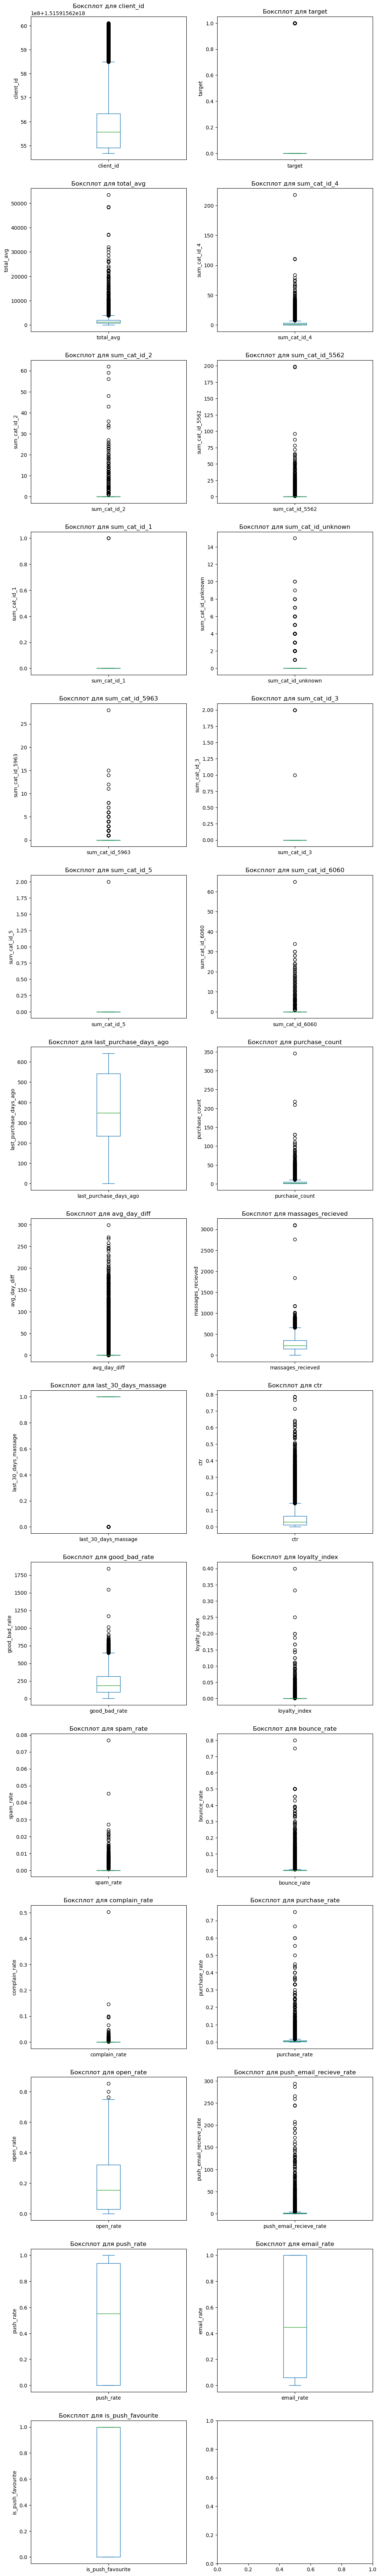

None

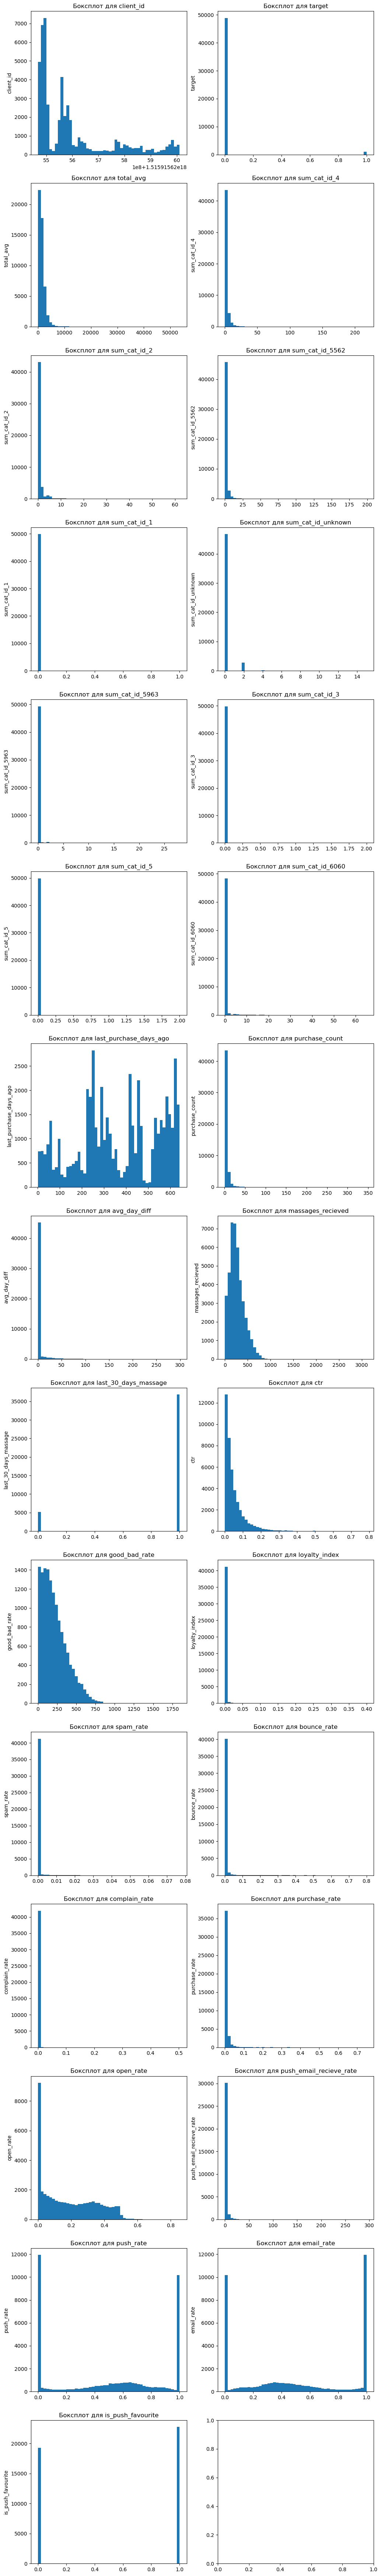

None

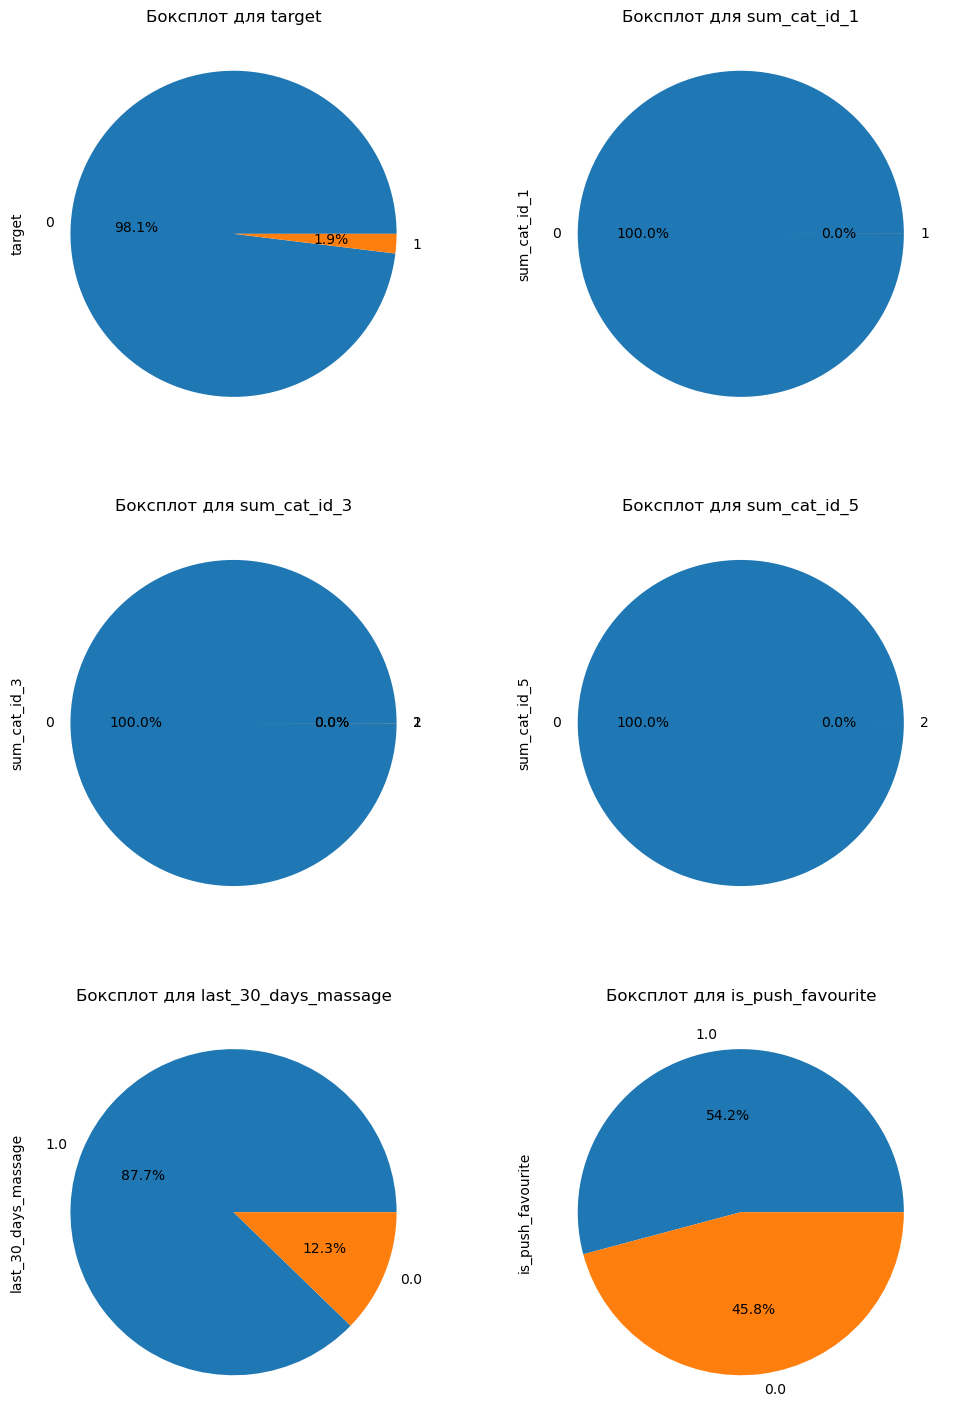

None

In [44]:
display(boxplot_constructor(df, 2))
display(hist_constructor(df, 2))
display(pie_constructor(df, 2))

Так лень описывать 40 графиков, я лучше останавлюсь на том, что действительно в дальнейшем пригодится

1) Есть дисбаланс классов (хоть, ROC_AUC к дисбалансу не чувствительна, просто будем держать в голове, что можно попробовать сэмплировать данные)
2) Некоторые данные в принципе не несут в себе полезной информации. Собственно, можно сразу увидеть, что показатели суммы количества купленных товаров по категориям 1, 3, 5 будут являться лишними для модели, так как не содержат в себе полезной нагрузки.
3) Почти по всем показателям очень тяжёлый правый хвост с аномальными значениями. Так как это, скорее всего, аутентичные данные, а не ошибки (тем более что таких данных оооочень много), то, вероятно, лучше их не удалять. Для того, чтобы сгладить аномалии можно взять логарифм по каждому такому показателю

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   client_id                49849 non-null  int64  
 1   target                   49849 non-null  int64  
 2   total_avg                49849 non-null  float64
 3   sum_cat_id_4             49849 non-null  int64  
 4   sum_cat_id_2             49849 non-null  int64  
 5   sum_cat_id_5562          49849 non-null  int64  
 6   sum_cat_id_1             49849 non-null  int64  
 7   sum_cat_id_unknown       49849 non-null  int64  
 8   sum_cat_id_5963          49849 non-null  int64  
 9   sum_cat_id_3             49849 non-null  int64  
 10  sum_cat_id_5             49849 non-null  int64  
 11  sum_cat_id_6060          49849 non-null  int64  
 12  last_purchase_days_ago   49849 non-null  int64  
 13  purchase_count           49849 non-null  int64  
 14  avg_day_diff          

In [52]:
# Переводим категориальные признаки в строковые, чтобы логарифм не брался по флагам и идентификаторам
cols_to_log = df.select_dtypes(include=np.number).columns.difference(['client_id', 'last_30_days_massage', 'is_push_favourite', 'target'])

# так как в данных достоверно есть нули и нет отрицательных значений, берём натуральный логарифм 1+х
df[cols_to_log] = np.log1p(df[cols_to_log])

# Теперь обработаем пропуски двойным категориальным заполнением. Признаком, который разделяет данные лучше всего, является сам таргет

# Записываем наименования столбцов, в которых есть пропуски

cols_nans = df.columns[df.isna().any()].to_list()

# В силу специфичности функции категориального заполнения (он воспринимает признаки как категориальные только тогда, когда они имеют строковый тип)
# Необходимо переделать тип функции
df[['last_30_days_massage', 'is_push_favourite']] = df[['last_30_days_massage', 'is_push_favourite']].astype('str')
df[['last_30_days_massage', 'is_push_favourite']] = df[['last_30_days_massage', 'is_push_favourite']].replace('nan', np.nan)

# Заполняем по таргету и любимому типу коммуникации клиента
for col in cols_nans:
    df = cats_fillna(df, 'target', 'is_push_favourite', col)

# Проверяем, чтобы всё заполнилось
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   client_id                49849 non-null  int64  
 1   target                   49849 non-null  int64  
 2   total_avg                49849 non-null  float64
 3   sum_cat_id_4             49849 non-null  float64
 4   sum_cat_id_2             49849 non-null  float64
 5   sum_cat_id_5562          49849 non-null  float64
 6   sum_cat_id_1             49849 non-null  float64
 7   sum_cat_id_unknown       49849 non-null  float64
 8   sum_cat_id_5963          49849 non-null  float64
 9   sum_cat_id_3             49849 non-null  float64
 10  sum_cat_id_5             49849 non-null  float64
 11  sum_cat_id_6060          49849 non-null  float64
 12  last_purchase_days_ago   49849 non-null  float64
 13  purchase_count           49849 non-null  float64
 14  avg_day_diff          

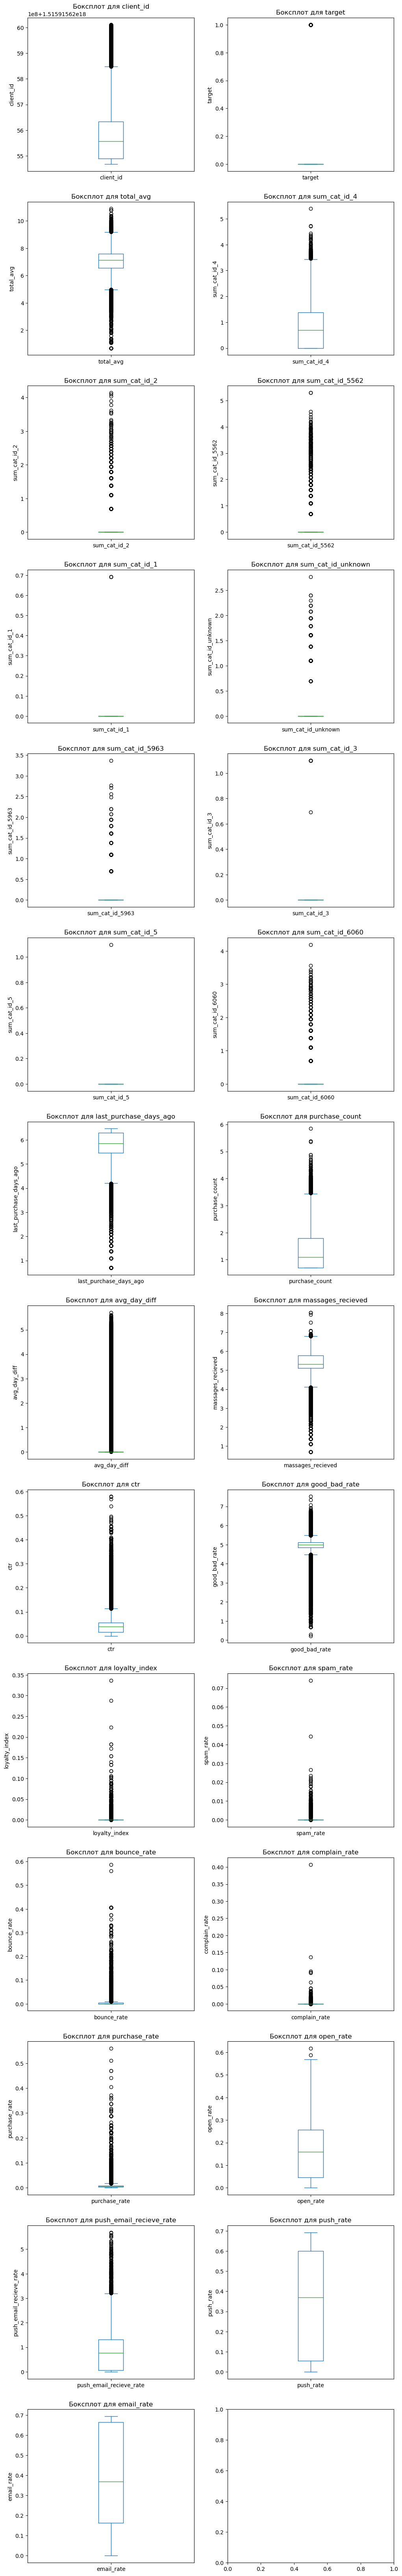

None

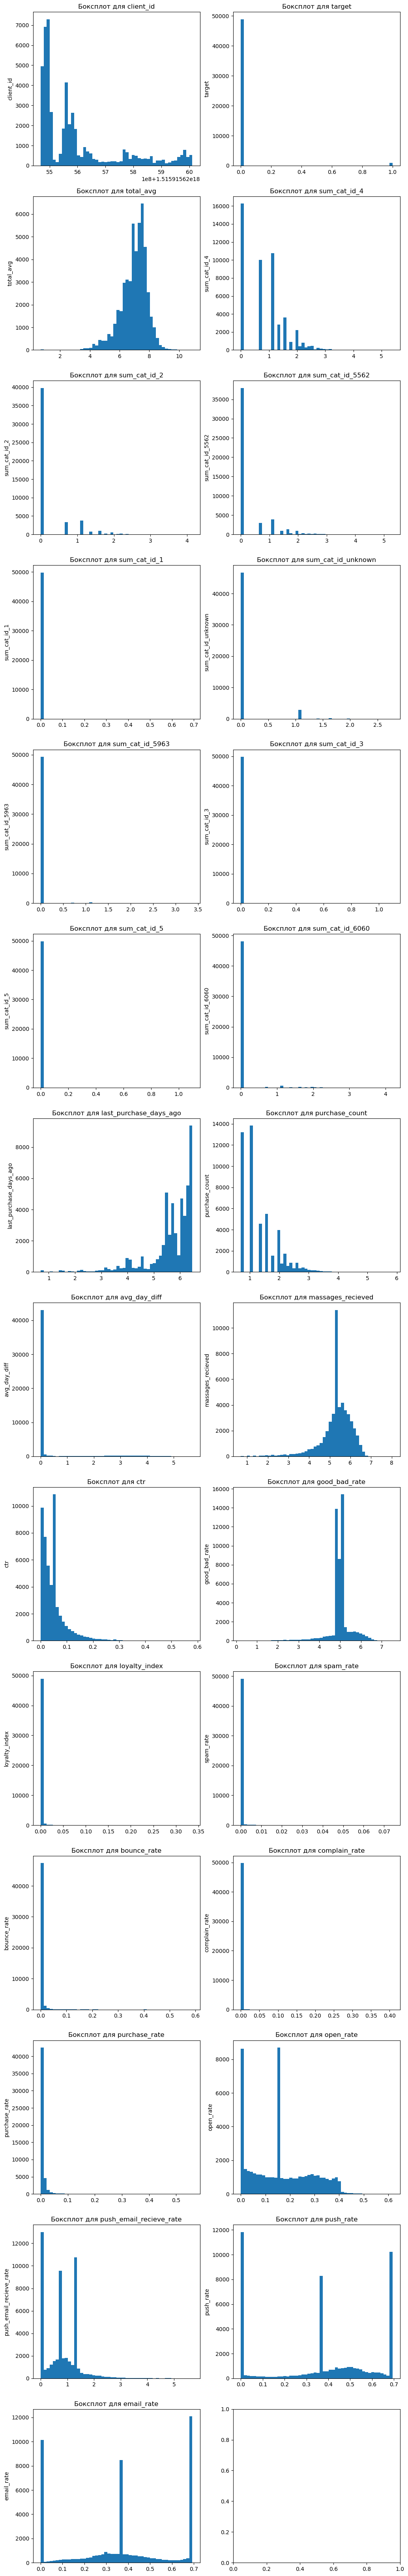

None

In [55]:
display(boxplot_constructor(df, 2))
display(hist_constructor(df, 2))

Хвосты очень заметно срезались)))))

По некоторым столбцам распределение даже стало нормальным, правда, после категориального заполнения, на медианных значениях теперь есть выбросы. Это не критично, но изменяет дисперсию в этих показателях, что не есть хорошо

Text(0.5, 1.0, 'Матрица корреляции признаков модели регрессии')

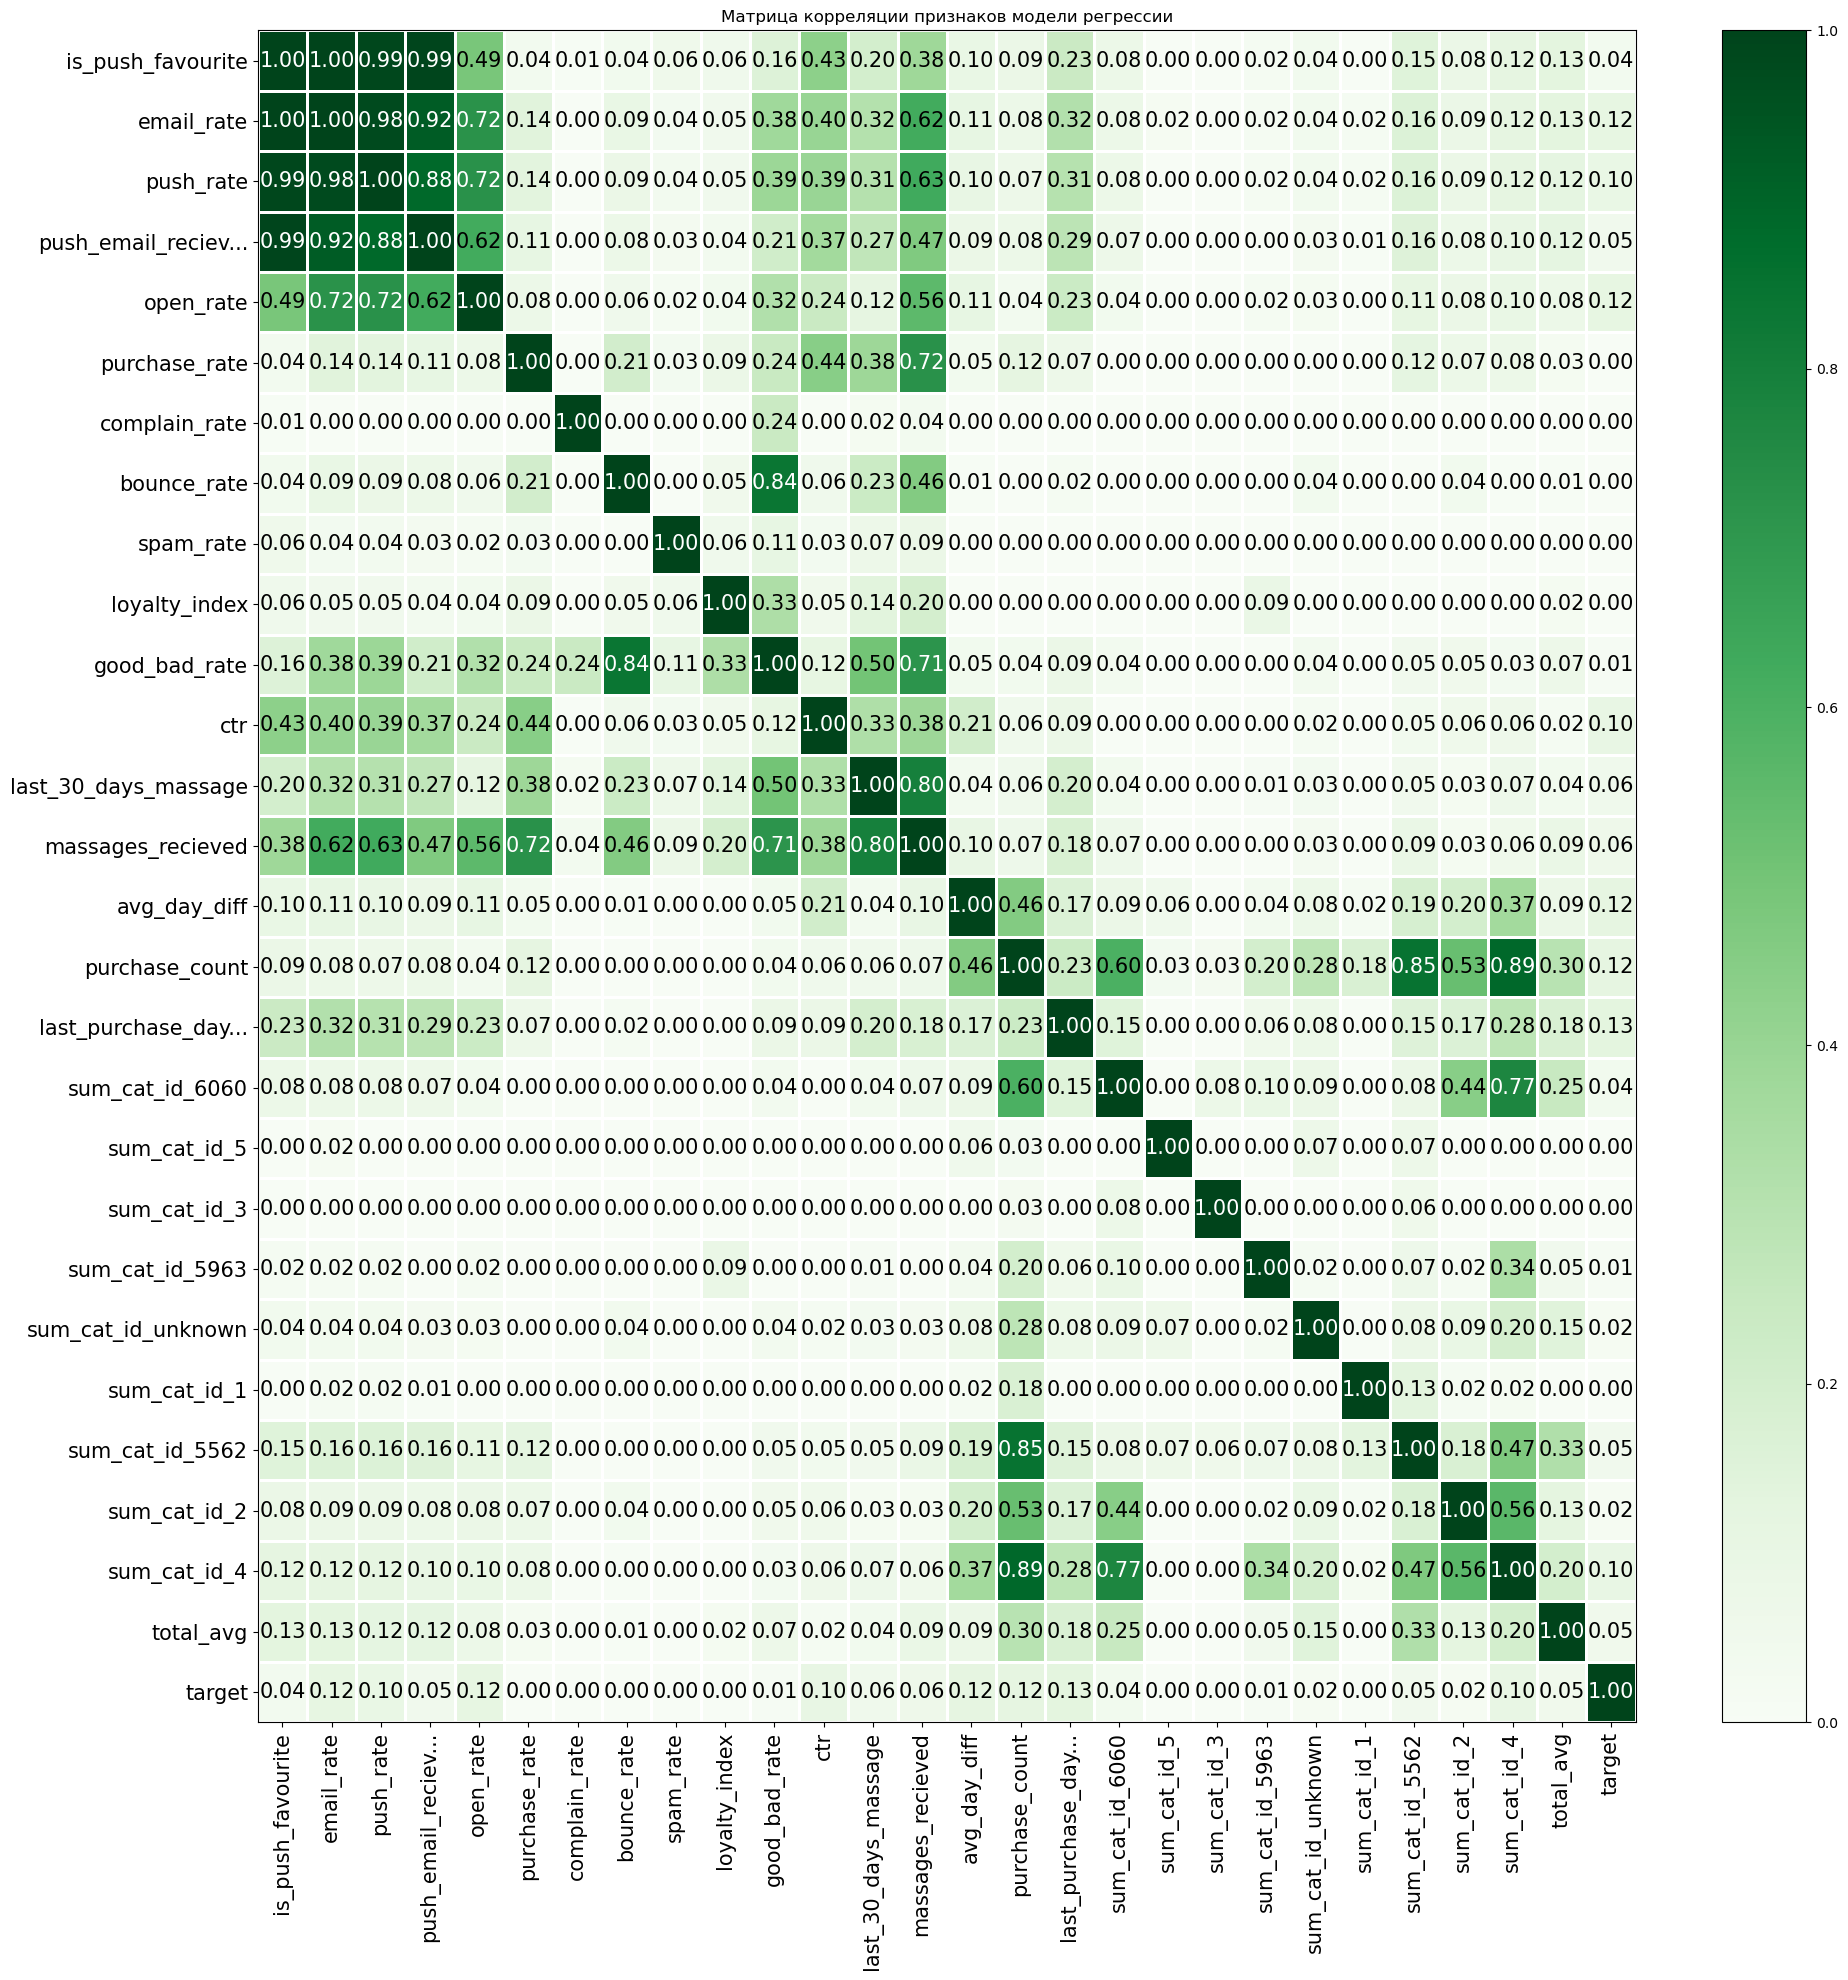

In [56]:
data_clf, int_cols_clf = phik_data(df)
phik_matrix_clf = phik.phik_matrix(data_clf, interval_cols=int_cols_clf)

plot_correlation_matrix(
    phik_matrix_clf.values,
    x_labels=phik_matrix_clf.columns,
    y_labels=phik_matrix_clf.index,
    vmin=0, vmax=1, color_map='Greens',
    title='Матрица корреляции признаков',
    fontsize_factor=1.5,
    figsize=(20,20)
)
plt.title('Матрица корреляции признаков модели регрессии')

In [57]:
# Выводим на экран самые важные признаки
display('Корреляция признаков в модели классификации', phik_matrix_clf['target'].sort_values(ascending=False))
# Удаляем признаки, по которым мы наблюдаем мультиколлинеарность и, собственно, идентификатор, также удаляем столбцы с наименее важными признаками
df = data_drop(df, phik_matrix_clf, 'target').drop(['client_id'], axis=1)

df.info()

'Корреляция признаков в модели классификации'

target                    1.00
last_purchase_days_ago    0.13
avg_day_diff              0.12
purchase_count            0.12
open_rate                 0.12
email_rate                0.12
sum_cat_id_4              0.10
ctr                       0.10
push_rate                 0.10
massages_recieved         0.06
last_30_days_massage      0.06
total_avg                 0.05
sum_cat_id_5562           0.05
push_email_recieve_rate   0.05
sum_cat_id_6060           0.04
is_push_favourite         0.04
sum_cat_id_unknown        0.02
sum_cat_id_2              0.02
good_bad_rate             0.01
sum_cat_id_5963           0.01
sum_cat_id_3              0.00
sum_cat_id_5              0.00
sum_cat_id_1              0.00
loyalty_index             0.00
spam_rate                 0.00
purchase_rate             0.00
bounce_rate               0.00
complain_rate             0.00
Name: target, dtype: float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target                   49849 non-null  int64  
 1   total_avg                49849 non-null  float64
 2   sum_cat_id_4             49849 non-null  float64
 3   sum_cat_id_5562          49849 non-null  float64
 4   sum_cat_id_6060          49849 non-null  float64
 5   last_purchase_days_ago   49849 non-null  float64
 6   purchase_count           49849 non-null  float64
 7   avg_day_diff             49849 non-null  float64
 8   massages_recieved        49849 non-null  float64
 9   last_30_days_massage     49849 non-null  object 
 10  ctr                      49849 non-null  float64
 11  open_rate                49849 non-null  float64
 12  push_email_recieve_rate  49849 non-null  float64
 13  push_rate                49849 non-null  float64
 14  email_rate            

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target                   49849 non-null  int64  
 1   total_avg                49849 non-null  float64
 2   sum_cat_id_4             49849 non-null  float64
 3   sum_cat_id_5562          49849 non-null  float64
 4   sum_cat_id_6060          49849 non-null  float64
 5   last_purchase_days_ago   49849 non-null  float64
 6   purchase_count           49849 non-null  float64
 7   avg_day_diff             49849 non-null  float64
 8   massages_recieved        49849 non-null  float64
 9   last_30_days_massage     49849 non-null  float64
 10  ctr                      49849 non-null  float64
 11  open_rate                49849 non-null  float64
 12  push_email_recieve_rate  49849 non-null  float64
 13  push_rate                49849 non-null  float64
 14  email_rate            

P.S. Вообще, наверное, надо записывать айдишники куда-то. Типа бизнесу здесь не модель же сама по себе нужна, а имена клиентов, для кого рассылку делать

## Модели

In [61]:
# Проводим разделение данных
X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE, 
                                                    stratify=y)

# Выделяем нужные столбцы
num_cols, cat_cols = col_names_func(X_train)

# Через написанную функцию вызываем пайплайн кодирования признаков
preprocessor = preprocessor_creator(cat_cols,
                                    num_cols)


# Кодируем данные через препроцессор
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Получаем имена фич
feature_names = preprocessor.get_feature_names_out()

# Кодируем целевой признак
y_encoder = LabelEncoder()
y_train_encoded = y_encoder.fit_transform(y_train)

'''
Оверсэмплинг не помогает((((
smote = SMOTE()
X_train_encoded, y_train_encoded = smote.fit_resample(X_train_encoded, y_train_encoded)

from imblearn.over_sampling import ADASYN
ADASYN = ADASYN()
X_train_sampled, y_train_sampled = ADASYN.fit_resample(X_train_encoded, y_train_encoded)
'''

display(X_train_encoded.shape)
display(y_train_encoded.shape)
display(X_test_encoded.shape)

(37386, 15)

(37386,)

(12463, 15)

Вообще, я парень простой, пробуем все модели, валидируем их и выбираем лучшую))

ROC AUC score: 0.4973

Confusion Matrix:
True Negatives: 12003, False Positives: 220
False Negatives: 237, True Positives: 3


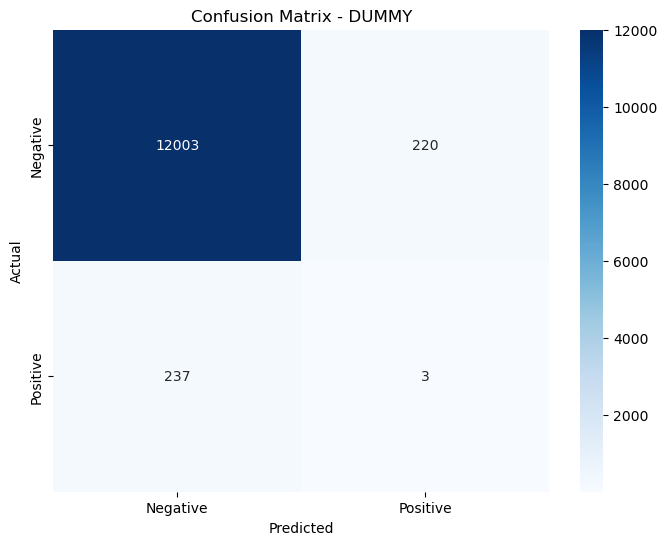

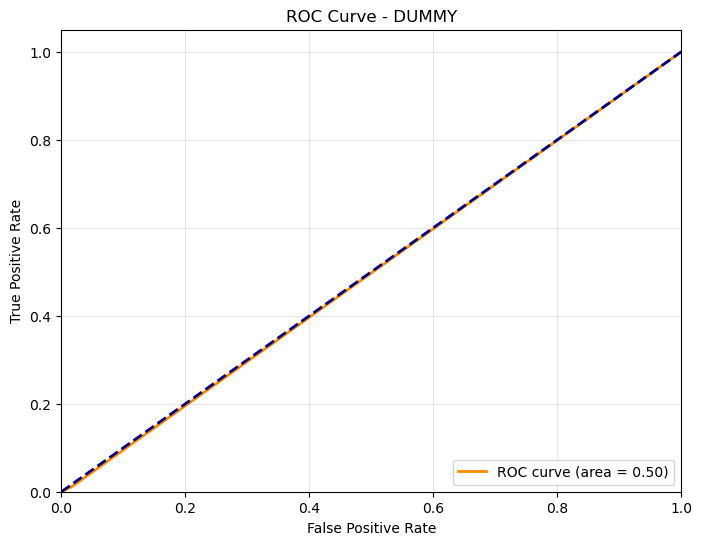

In [32]:
# Проверяем данные на "тупой" модели, получаем тресхолд для нашей модели
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train_encoded, y_train_encoded)
y_proba = dummy_clf.predict_proba(X_test_encoded)[:, 1]
y_pred = dummy_clf.predict(X_test_encoded)

roc_auc = roc_auc_score(y_test, y_proba)
evaluate_classifier(dummy_clf, X_test_encoded, y_test, model_name="DUMMY")

C:\dev\anaconda3\envs\anaconda-2025.06-py3.11\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\dev\anaconda3\envs\anaconda-2025.06-py3.11\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('models',
                                              DecisionTreeClassifier())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'models': [LogisticRegression(random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 10),
                                         'models__penalty': ['l2'],
                                         'models__solver': ['liblinear',
                                                            'saga']}],
                   random_state=42, scoring='roc_auc')

ROC AUC score: 0.7731

Confusion Matrix:
True Negatives: 12222, False Positives: 1
False Negatives: 240, True Positives: 0


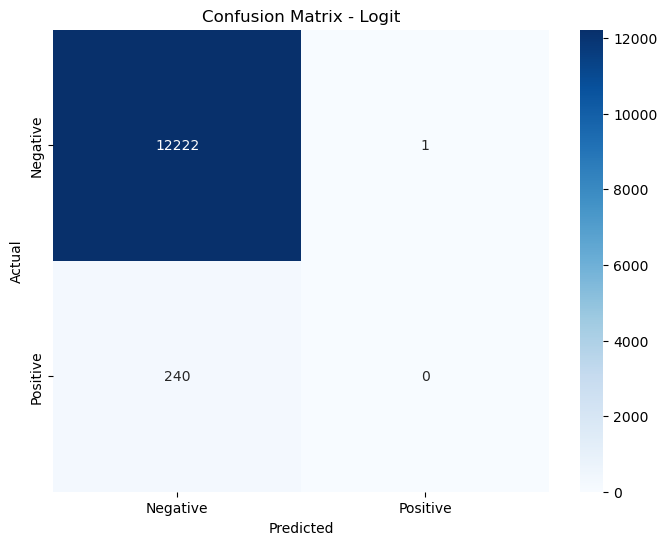

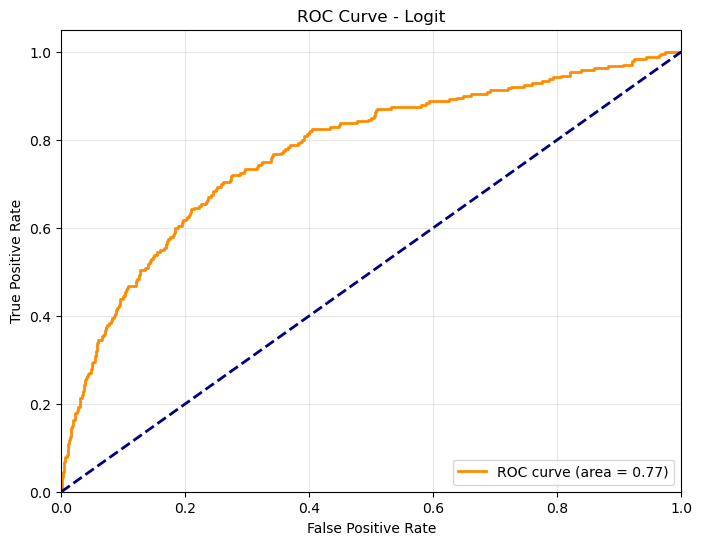

In [33]:
# Создаём пайплайн с моделью
clf_pipe = Pipeline([
    ('models', DecisionTreeClassifier())
])


param_grid_log = [
    # Логистическая регрессия
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE,
                                      solver='liblinear')],
        'models__penalty': ['l2'],
        'models__solver': ['liblinear', 'saga'],
        'models__C': range(1,10)
    }   
]

rscv_log = RandomizedSearchCV(clf_pipe, 
                          param_grid_log, 
                          cv=5,
                          scoring='roc_auc',
                          n_jobs = -1,
                          random_state=RANDOM_STATE,
                          n_iter=100)

rscv_log = rscv_log.fit(X_train_encoded, y_train_encoded)

estimator_log = rscv_log.best_estimator_
model_log = rscv_log.best_estimator_['models']

display(rscv_log)

evaluate_classifier(model_log, X_test_encoded, y_test, model_name="Logit")

Вообще никакая модель, ни один объект положительного класса не нашла

In [ ]:
param_grid_knn = [
    # Метод k ближайших соседей
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20), 
        'models__weights': ['uniform', 'distance'],
        'models__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
        'models__leaf_size': [10, 20, 30, 40, 50], 
        'models__p': [1, 2], 
    }

    
]

rscv_knn = RandomizedSearchCV(clf_pipe, 
                          param_grid_knn, 
                          cv=5,
                          scoring='roc_auc',
                          n_jobs = -1,
                          random_state=RANDOM_STATE,
                          n_iter=20)

rscv_knn = rscv_knn.fit(X_train_encoded, y_train_encoded)

estimator_knn = rscv_knn.best_estimator_
model_knn = rscv_knn.best_estimator_['models']

display(rscv_knn)

evaluate_classifier(model_knn, X_test_encoded, y_test, model_name="KNN")

Ну тут я вообще воздержусь от комментариев))

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('models',
                                              DecisionTreeClassifier())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions=[{'models': [RandomForestClassifier(random_state=42)],
                                         'models__bootstrap': [True, False],
                                         'models__class_weight': ['balanced',
                                                                  'balanced_subsample',
                                                                  None],
                                         'models__max_depth': [None, 10, 20,
                                                               30],
                                         'models__max_features': ['sqrt',
                                                                  'log2',
                                                                  None],
                                         'models__min_samples_leaf': [1, 2, 4],
                                         'models__min_samples_split': [2, 5,
                                                                       10],
                                         'models__n_estimators': [100]}],
                   random_state=42, scoring='roc_auc')

ROC AUC score: 0.8899

Confusion Matrix:
True Negatives: 12223, False Positives: 0
False Negatives: 141, True Positives: 99


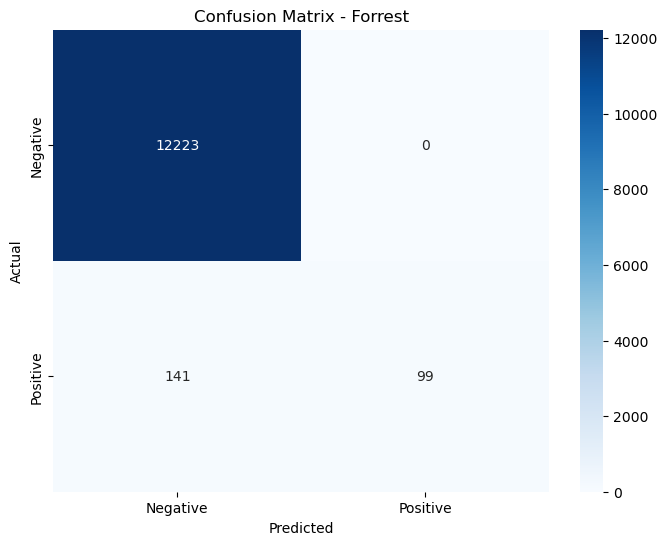

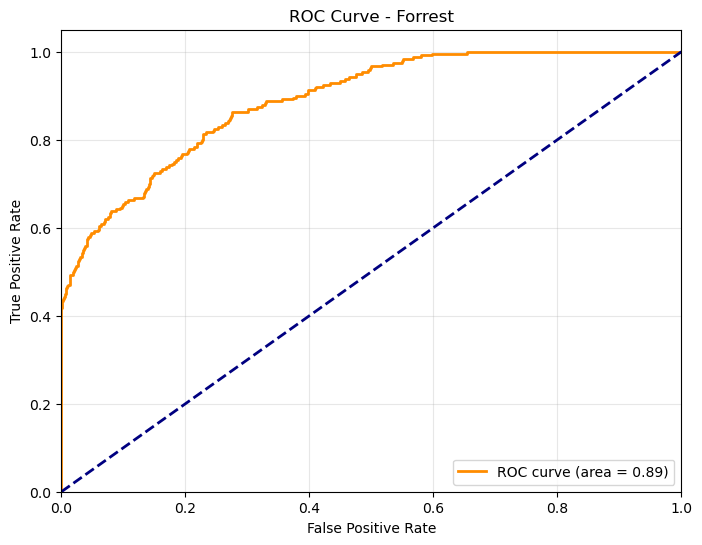

In [34]:

param_grid_forrest = [
    # Случайный лес
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100],
        'models__max_depth': [None, 10, 20, 30],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 4],
        'models__max_features': ['sqrt', 'log2', None],
        'models__bootstrap': [True, False],
        'models__class_weight': ['balanced', 'balanced_subsample', None] 
    }

    
]

rscv_forrest = RandomizedSearchCV(clf_pipe, 
                          param_grid_forrest, 
                          cv=5,
                          scoring='roc_auc',
                          n_jobs = -1,
                          random_state=RANDOM_STATE,
                          n_iter=100)

rscv_forrest = rscv_forrest.fit(X_train_encoded, y_train_encoded)

estimator_forrest = rscv_forrest.best_estimator_
model_forrest = rscv_forrest.best_estimator_['models']

display(rscv_forrest)

evaluate_classifier(model_forrest, X_test_encoded, y_test, model_name="Forrest")

Отличная модель, относительно хорошо распознаёт положительный класс, имеет максимальную специфичность

0:	learn: 0.6730097	total: 53.1ms	remaining: 10.6s
1:	learn: 0.6532819	total: 79.3ms	remaining: 7.85s
2:	learn: 0.6349382	total: 89.9ms	remaining: 5.91s
3:	learn: 0.6160722	total: 138ms	remaining: 6.77s
4:	learn: 0.5984140	total: 182ms	remaining: 7.08s
5:	learn: 0.5820910	total: 198ms	remaining: 6.41s
6:	learn: 0.5658444	total: 242ms	remaining: 6.66s
7:	learn: 0.5460863	total: 284ms	remaining: 6.82s
8:	learn: 0.5301359	total: 329ms	remaining: 6.97s
9:	learn: 0.5151653	total: 350ms	remaining: 6.65s
10:	learn: 0.4997515	total: 394ms	remaining: 6.76s
11:	learn: 0.4843571	total: 439ms	remaining: 6.87s
12:	learn: 0.4708104	total: 480ms	remaining: 6.91s
13:	learn: 0.4581413	total: 521ms	remaining: 6.92s
14:	learn: 0.4439792	total: 566ms	remaining: 6.98s
15:	learn: 0.4325709	total: 609ms	remaining: 7s
16:	learn: 0.4207944	total: 650ms	remaining: 7s
17:	learn: 0.4098130	total: 700ms	remaining: 7.08s
18:	learn: 0.3990928	total: 754ms	remaining: 7.18s
19:	learn: 0.3883558	total: 806ms	remaining:

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('models',
                                              DecisionTreeClassifier())]),
                   n_iter=25, n_jobs=-1,
                   param_distributions=[{'models': [<catboost.core.CatBoostClassifier object at 0x00000000172FA1D0>],
                                         'models__depth': [4, 6, 8, 10],
                                         'models__iterations': [100, 200, 300],
                                         'models__learning_rate': [0.01, 0.05,
                                                                   0.1]},
                                        {'models': [LGBMClassifier(random_state=42)],
                                         '...
                                                                  max_cat_to_onehot=None,
                                                                  max_delta_step=None,
                                                                  max_depth=None,
                                                                  max_leaves=None,
                                                                  min_child_weight=None,
                                                                  missing=nan,
                                                                  monotone_constraints=None,
                                                                  multi_strategy=None,
                                                                  n_estimators=None,
                                                                  n_jobs=None,
                                                                  num_parallel_tree=None, ...)],
                                         'models__learning_rate': [0.01, 0.05,
                                                                   0.1],
                                         'models__max_depth': [4, 6, 8, 10],
                                         'models__n_estimators': [100, 200,
                                                                  300]}],
                   random_state=42, scoring='roc_auc')

ROC AUC score: 0.8996

Confusion Matrix:
True Negatives: 12223, False Positives: 0
False Negatives: 141, True Positives: 99


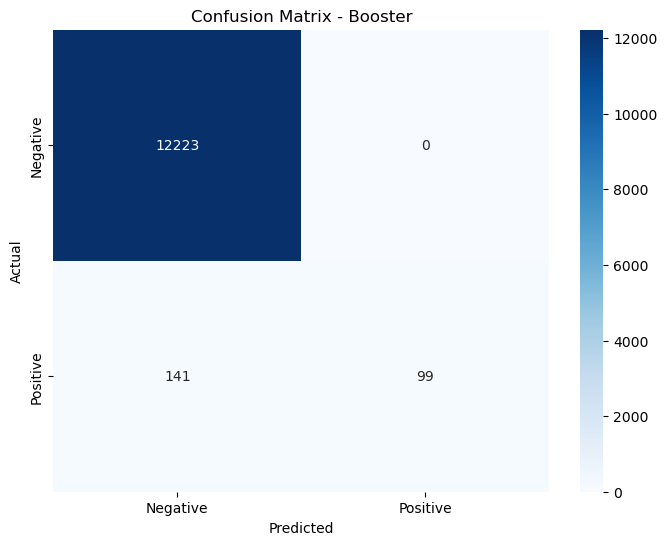

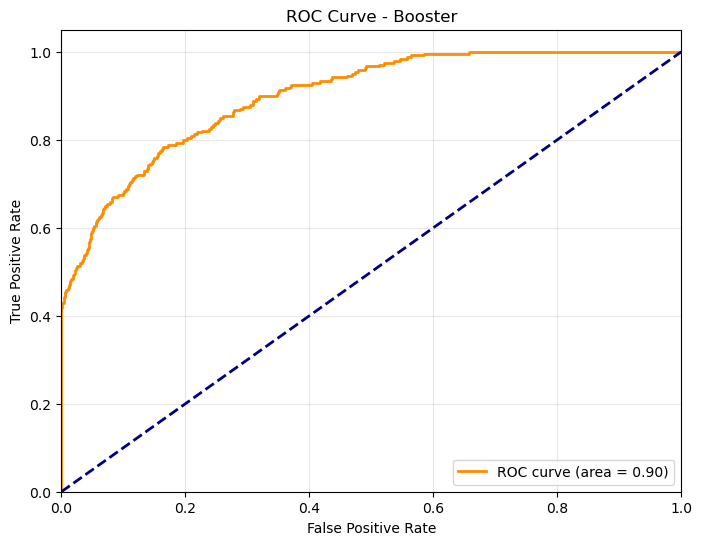

In [62]:

param_grid_boosters = [
    # Бустеры
    {
        'models': [CatBoostClassifier(random_seed=RANDOM_STATE)],
        'models__iterations': [100, 200, 300],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__depth': [4, 6, 8, 10]
    },

    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 300],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__max_depth': [4, 6, 8, 10],
        'models__num_leaves': [30, 60, 90, 120]
    },

    {
        'models': [XGBClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 300],
        'models__learning_rate': [0.01, 0.05, 0.1],
        'models__max_depth': [4, 6, 8, 10]
    }

    
]

rscv_boosters = RandomizedSearchCV(clf_pipe, 
                          param_grid_boosters, 
                          cv=5,
                          scoring='roc_auc',
                          n_jobs = -1,
                          random_state=RANDOM_STATE,
                          n_iter=25)

rscv_boosters = rscv_boosters.fit(X_train_encoded, y_train_encoded)

estimator_boosters = rscv_boosters.best_estimator_
model_boosters = rscv_boosters.best_estimator_['models']

display(rscv_boosters)

evaluate_classifier(model_boosters, X_test_encoded, y_test, model_name="Booster")

Эта модель чуть хуже распознаёт положительный класс

По итогу лучшей моделью оказалась модель градиентного бустинга. Неплохие результаты показали случайные леса. Я бы всё же выбирал модель бустинга, она чуть лучше распознаёт положительный класс, хоть и два раза выдала ложноположительный результат. Мне кажется, вообще ничего страшного не будет, если два человека получат лишние рассылки. Я бы в принципе использовал здесь полноту как целевую метрику (хотя конечно заказчику виднее). Я не знаю издержек от получения рассылки "лишними" людьми и оценки упущенной выгоды от неполучения "нужным" человеком сообщения, но почему-то мне кажется, лучше лишнее сообщение прислать, чем терять клиента

## Интерпретируем работу моделей

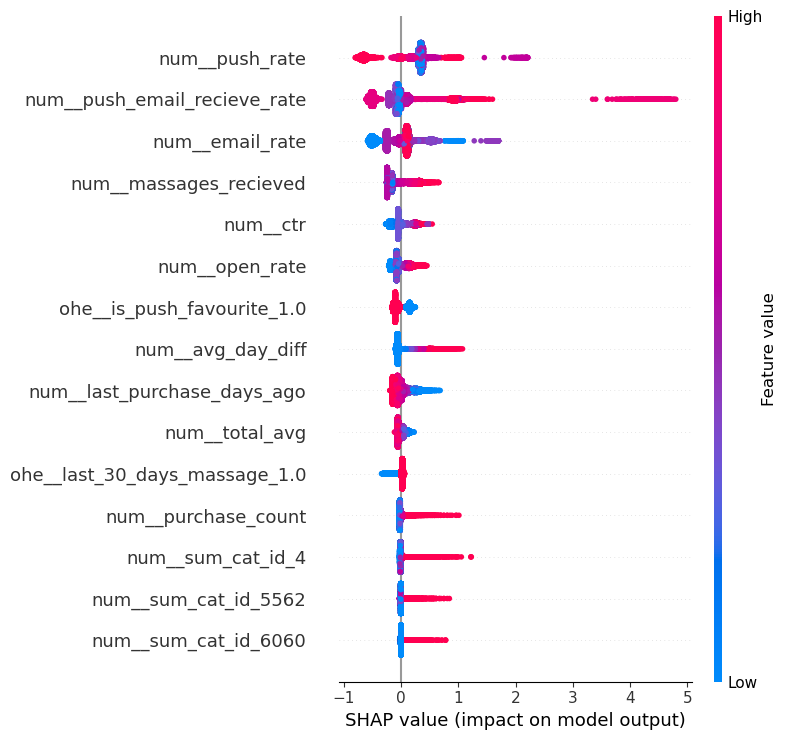

In [63]:
explainer = shap.Explainer(model_boosters)
shap_values = explainer(X_train_encoded)
shap.summary_plot(shap_values, X_train_encoded, feature_names=feature_names)

Анализ важности признаков показывает, что самыми важными признаками для модели являются показатели, связанные с рассылкой сообщений и покупательской активностью клиента в последнее время. 

1. Самым важным признаком модель посчитала соотношение сообщений, полученных по электронной почте и через пуш-уведомления: низкие значения (предпочтительна эл. почта) почти никак не влияли на модель, а высокие значения могли как повысить вероятность положительного класса, так и снизить. Средние значения (как я понял, значения около единицы, то есть явного предпочтения нет) обычно снижают вероятность единицы в таргете
2. Количество полученных сообщений: Обычно, чем больше сообщений, тем более вероятно, что покупатель совершит покупку в следующие 90 дней
3. Конверсия в открытие: чем больше, тем лучше (не работает для единицы)
4. CTR: прямая зависимость (чем больше, тем лучше)
5. Количество дней с последней покупки: обратная линейная зависимость
6. Флаг на наличие сообщений в последние 30 дней: прямая зависимость

Признаки, сконструированные из датасета с информацией о покупках, вообще по факту никак и не сказалась на работе модели

## Вывод

В ходе проекта была проведена работа с данными, в ходе которой были:

1. Выделены основные данные для работы: отброшены таблицы с данными по рассылкам
2. Сконструированы новые признаки: самыми полезными для работы модели оказались агрегированные показатели, сконструированные на основе данных по сообщениям
3. Опробованы различные модели классификации, лучшей из которых оказалась модель градиентного бустинга с показателем целевой метрикой, равной 0,9
4. Был проведён анализ важности признаков, в ходе которого выявились признаки, которые являются наиболее важные фичи для работы модели (и соответственно, на которые надо смотреть в первую очередь при анализе для выявления целевой группы клиентов).

Таковыми являются:
- факт получения сообщений за последний месяц
- предпочтительный канал связи клиента (по клиентам, получающим рассылки в основном через пуш-уведомления, вероятность покупки товаров в следующие 90 дней выше)
- CTR
- Конвертация в открытие ссылки

In [65]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
